# 1. Operator $U_x$ in `Cirq`:

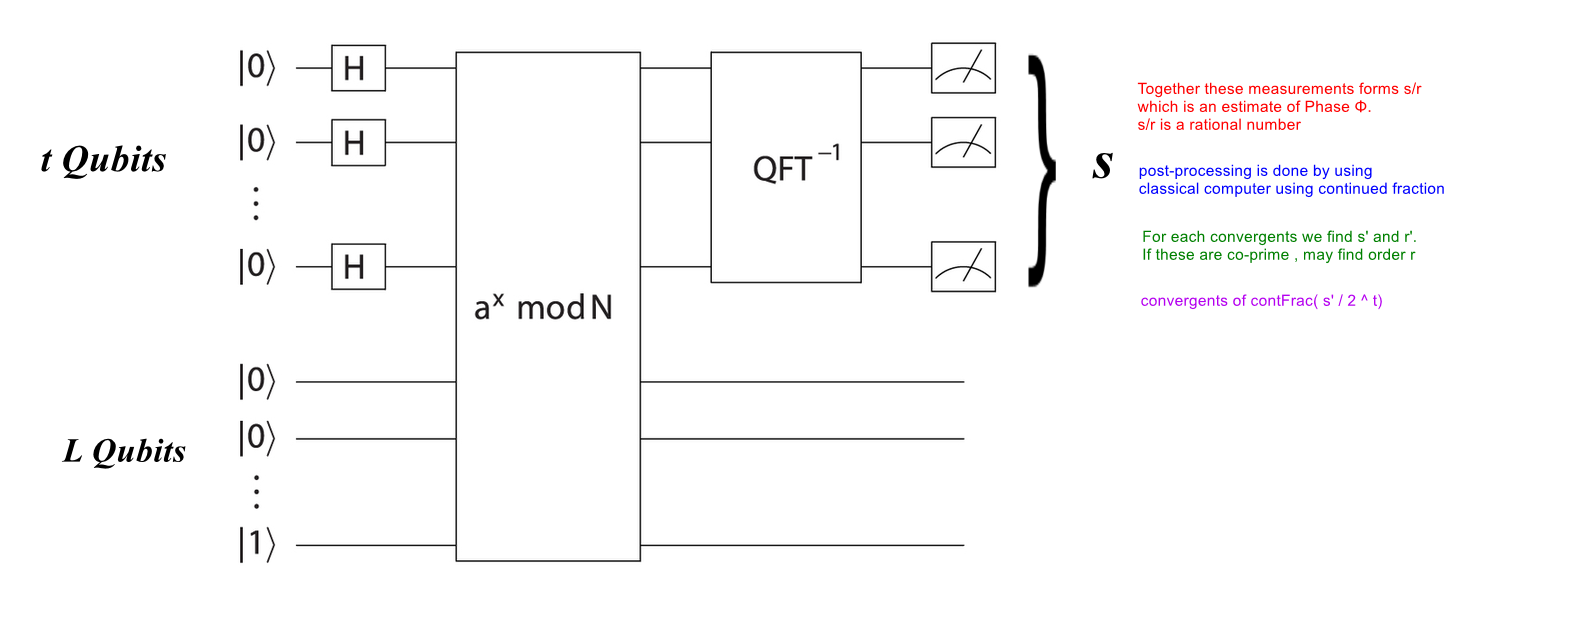

#### NOTE: 

* The first register has $t$ qubits.
* The second register has $L$ qubits.

In [31]:
import math 
# initialize the paramenters as per your requirement
# x = 3
# N = 20

x = 8
N = 99


# L = ⌈log2(N)⌉
L = math.ceil(math.log2(N))

# let's pick error e=0.1
e = 0.1
# t = 2L + 1 + ⌈log2(2 + 1/(2e))⌉
t = 2*L + 1 + math.ceil(math.log2(2 + 1/(2*math.e)))

print("Random base of exponent: x = ", x)
print("Number to be factored: N = ", N)
print("Number of Bits: L = ", L)
print("Error epsilon: e = ", e)
print("Number of registers in first : t =", t)
print("Total registers in both : t+L =", t+L)


Number to be factored: N =  99
Random base of exponent: x =  8
Number of Bits: L =  7
Error epsilon: e =  0.1
Number of registers in first : t = 17
Total registers in both : t+L = 24


In [24]:
import cirq
import numpy as np
import cirq
from cirq import H, SWAP
from cirq.circuits import InsertStrategy
from math import pi
import math 

# Define Functions: 

def contFrac(N):
    import math
    cf=[]
    while True:
        cf.append(int(N))
        f = N - N//1
        if f < 0.0001:  # or whatever precision you consider close enough to 0
            break
        N = 1/f
        if(math.ceil(N)-N<0.0001):
            N=round(N)
    return cf


def convergents(cf):
    from fractions import Fraction 
    c=[] 
    cv=[]
    
    for i in range(len(cf)):
        c.append(cf[i])
        for j in range(i-1,-1,-1):
            c[i] = 1/c[i]+ cf[j]
        cv.append(Fraction(c[i]).limit_denominator(10000))
    return cv


def opUx(N, x):
    
    k = 1
    while(N > 2**k):
        k = k + 1
    u = np.zeros([2**k, 2**k], dtype = int) 
    for i in range(N):
        u[x*i % N][i] = 1
    for i in range(N, 2**k):
        u[i][i] = 1
    return cirq.MatrixGate(u, name='Ux').controlled()

def myInvQFT(qubits):

    circuit = cirq.Circuit() # create a circuit
    n = len(qubits)
    # swap the qubits
    for j in range(n//2): # integer division
        circuit.append(SWAP.on(qubits[j],qubits[n-j-1]), strategy = InsertStrategy.NEW)
    # inverted phase gates are applied in reverse order and before the hadamard gate
    for i in range(n-1,-1,-1):
        phase_divisor = 2**(n-i)
        for j in range(n-1,i,-1):
            circuit.append(cirq.CZPowGate(exponent = -2/phase_divisor).on(qubits[j],qubits[i]),
                           strategy = InsertStrategy.NEW)
            phase_divisor = phase_divisor / 2
        circuit.append(H(qubits[i]), strategy = InsertStrategy.NEW) # strategy is for the circuit to look neat
    
    return circuit


# default representation in Cirq is with decimal numbers
# with this function we convert the decimal numbers into binary (bitstrings)
def bitstring(bits):
    return "".join(str(int(b)) for b in bits)

# 2. Quantum Phase Algorithm:


In [29]:
# Quantum Phase Estimation Algorithm

import cirq
from cirq import X, measure


circuit = cirq.Circuit()

reg1 = [cirq.LineQubit(i) for i in range(t) ]
reg2 = [cirq.LineQubit(i) for i in range(t, t+L) ]

# Apply Hadamard gates to the qubits on the first register
circuit.append(cirq.H.on_each(reg1))

# set the last qubit in second register to |1>
circuit.append(X.on_each(reg2[-1]))

Ux = opUx(N, x)
# apply CU^(2^j) operators
for j in range(t):
    Uxj = Ux**(2**j)
    circuit.append(Uxj(reg1[t-j-1], *reg2))

# the algorithm has been described for the qubit order q0⊗...⊗qt-1
circuit += myInvQFT(reg1)

# Measure
circuit.append(measure(*reg1, key='result'))

# Execute the circuit
sim = cirq.Simulator()
samples = sim.run(circuit, repetitions=1000)




print("outcomes in binary:")
print(samples.histogram(key='result', fold_func=bitstring))

print()
print("outcomes in decimal:")
outcomes = samples.histogram(key='result')
print(outcomes) # output in decimal form, default in Cirq
print()

print("Observation samples:")
for outcome in outcomes:
    print(outcome, "\tobserved", outcomes[outcome], "times")

outcomes in binary:
Counter({'10000000000000000': 103, '11100110011001101': 89, '10011001100110011': 89, '00011001100110011': 87, '00000000000000000': 87, '01100110011001101': 79, '01001100110011010': 68, '10110011001100110': 51, '00110011001100110': 50, '11001100110011010': 49, '01001100110011001': 33, '10110011001100111': 30, '00110011001100111': 25, '11001100110011001': 24, '10110011001100101': 8, '01100110011001100': 8, '00011001100110100': 7, '11100110011001100': 6, '11001100110011100': 6, '00011001100110010': 6, '10110011001101000': 5, '01001100110011011': 5, '11001100110011011': 5, '00110011001100101': 4, '00110011001101001': 4, '01001100110011000': 4, '11001100110010111': 4, '10110011001100100': 3, '10011001100110100': 3, '01001100110010111': 3, '11001100110011000': 3, '01100110011001110': 2, '00110011001100010': 2, '11100110011001001': 2, '01100110011001011': 2, '01001100110011100': 2, '11100110011001110': 2, '01001100110010011': 2, '11001100110010011': 2, '00110011001100100':

### Note: 

For each observation you need to calculate the ration $ \frac{s}{2^t}$ where 
* $t $ is number of qubits in First Register. 
* $s $ is $s^{th}$ sample label 



In [35]:
# Set as per the maximum observed sample
s_dash = 39322

print("t=",t)
print("s'=",s_dash)
cf = contFrac(s_dash/2**t)  # s / 2 ^ t
cv = convergents(cf)
print(cf)
print(cv)

# NOTE: s' and r' must be CO PRIME 

t= 17
s'= 39322
[0, 3, 3, 3276, 2]
[Fraction(0, 1), Fraction(1, 3), Fraction(3, 10), Fraction(3, 10), Fraction(3, 10)]


## NOTE: 

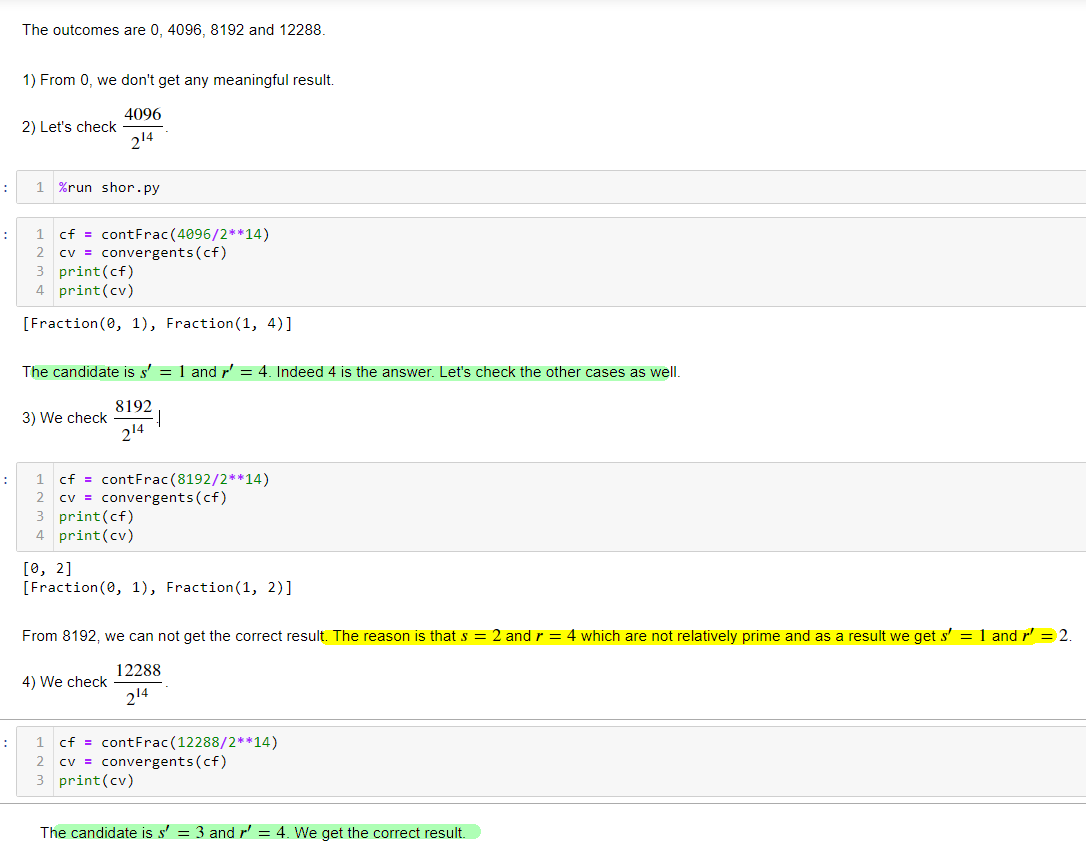